In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글폰트 지정
plt.rcParams['axes.unicode_minus']=False # 한글폰트 사용 시 -기호 깨지는 문제 해결

# df_가격 정제

In [2]:
df_가격 = pd.read_csv('C:\\Users\\정태빈\\Downloads\\품목_소매가_전부.csv', encoding = 'cp949')

# 컬럼 정리
df_가격.drop(columns = ['index'], inplace = True)
df_가격 = df_가격[['구분', '품목', '평균']]

# 컬럼명 수정
df_가격 = df_가격.rename(columns={'구분':'날짜', '전통시장':'전통시장가격', '유통업체':'유통업체가격', '평균':'평균가격', '품목':'품목명'})

# 형변환
df_가격['날짜'] = pd.to_datetime(df_가격['날짜'])

df_가격['평균가격'] = df_가격['평균가격'].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

df_가격 = df_가격.sort_values(['품목명', '날짜'], ascending=True)



# 품목별 단위 가격 계산 함수
def calculate_1kg_price(row):
    if row['품목명'] == '감자':  # 100g
        return row['평균가격'] * 10
    elif row['품목명'] == '건고추':  # 600g
        return row['평균가격'] * 10 / 6
    elif row['품목명'] == '무':  # 무는 한 개에 대략 1kg
        return row['평균가격']
    elif row['품목명'] == '배추':  # 1포기
        return row['평균가격'] * 3 / 10  # 표준규격 3포기 한 망에 10kg
    elif row['품목명'] == '시금치':  # 100g
        return row['평균가격'] * 10
    elif row['품목명'] == '쌀':  # 20kg
        return row['평균가격'] / 20
    elif row['품목명'] == '애호박':  # 1개 대략 300g
        return row['평균가격'] * 10 / 3
    elif row['품목명'] == '양배추':  # 1포기
        return row['평균가격'] * 10 / 11  # 양배추 1통은 일반적으로 1100g 전후의 상품이 선별되며, 1.5kg 내외의 상품도 있습니다
    elif row['품목명'] == '오이':  # 10개
        return row['평균가격'] / 2  # 오이 한 개 무게는 대략 200g -> 5개 1kg
    elif row['품목명'] == '콩나물':  # 340g
        return row['평균가격'] * 100 / 34
    elif row['품목명'] == '새송이버섯':  # 100g
        return row['평균가격'] * 10
    elif row['품목명'] == '팽이':  # 150g
        return row['평균가격'] * 100 / 15
    else:
        return row['평균가격']  # 기본적으로 변환하지 않은 값을 반환

# '단위가격' 컬럼 생성
df_가격['단위가격'] = df_가격.apply(calculate_1kg_price, axis=1)
df_가격['단위가격'] = df_가격['단위가격'].round(1)
df = df_가격

# 그래프 그릴 때 사용할 컬럼 생성
df['년월'] = df['날짜'].dt.strftime('%Y-%m')
df['년'] = df['날짜'].dt.year
df['월'] = df['날짜'].dt.month

print(df.info())

df

<class 'pandas.core.frame.DataFrame'>
Index: 65120 entries, 0 to 65119
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      65120 non-null  datetime64[ns]
 1   품목명     65120 non-null  object        
 2   평균가격    65120 non-null  float64       
 3   단위가격    65120 non-null  float64       
 4   년월      65120 non-null  object        
 5   년       65120 non-null  int32         
 6   월       65120 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), object(2)
memory usage: 3.5+ MB
None


,날짜,품목명,평균가격,단위가격,년월,년,월
0,2014-01-02,감자,202.0,2020.0,2014-01,2014,1
1,2014-01-03,감자,208.0,2080.0,2014-01,2014,1
2,2014-01-04,감자,208.0,2080.0,2014-01,2014,1
3,2014-01-05,감자,208.0,2080.0,2014-01,2014,1
4,2014-01-06,감자,281.0,2810.0,2014-01,2014,1
...,...,...,...,...,...,...,...
65115,2024-12-01,팽이,529.0,3526.7,2024-12,2024,12
65116,2024-12-02,팽이,529.0,3526.7,2024-12,2024,12
65117,2024-12-03,팽이,530.0,3533.3,2024-12,2024,12
65118,2024-12-04,팽이,534.0,3560.0,2024-12,2024,12


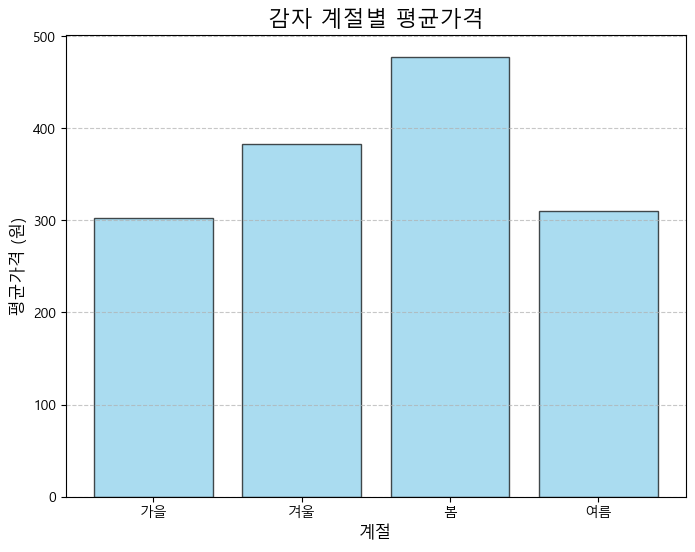

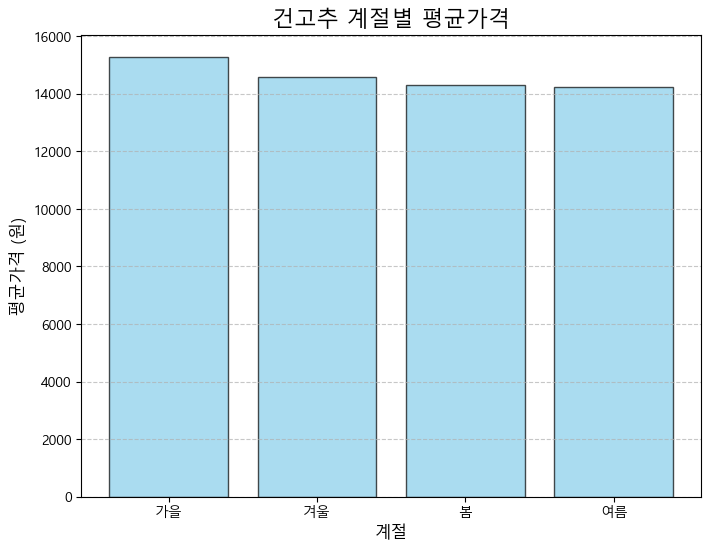

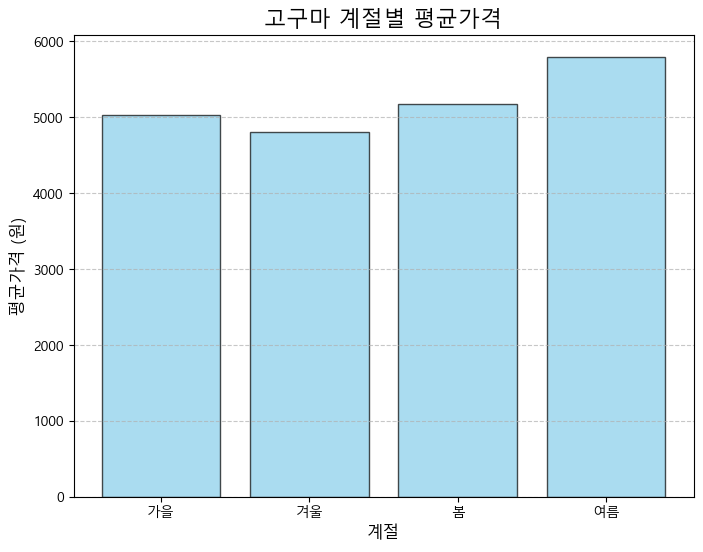

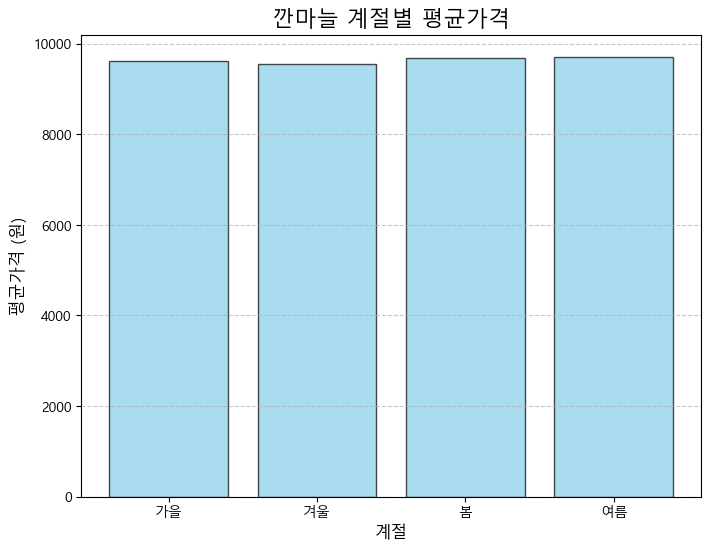

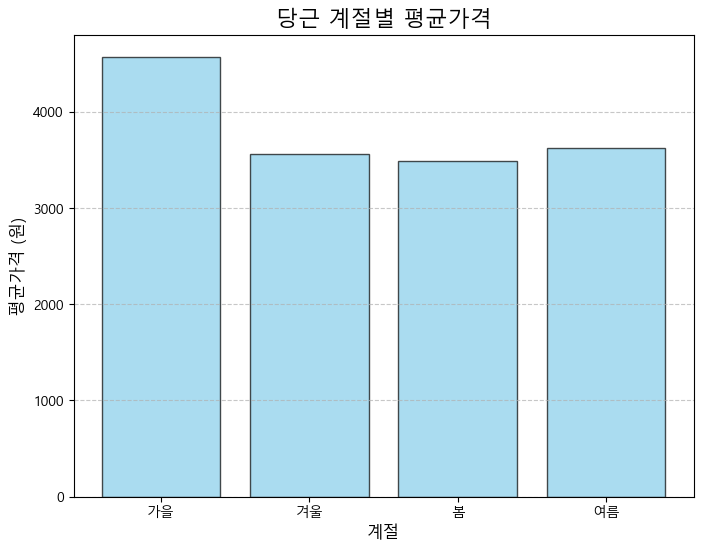

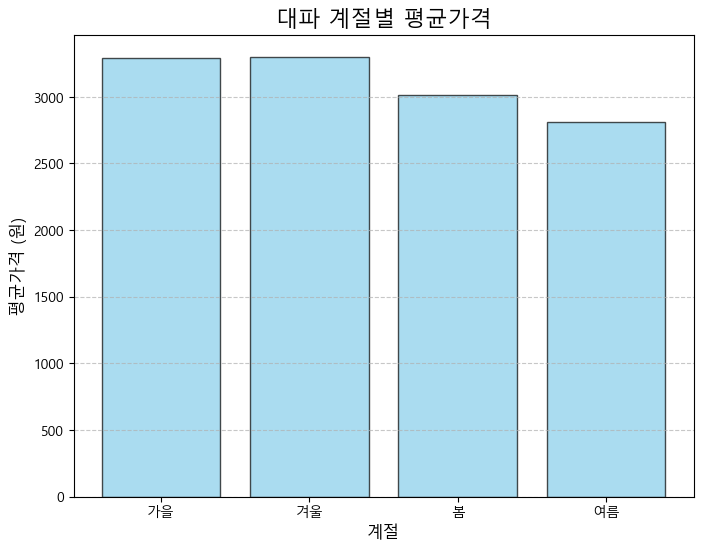

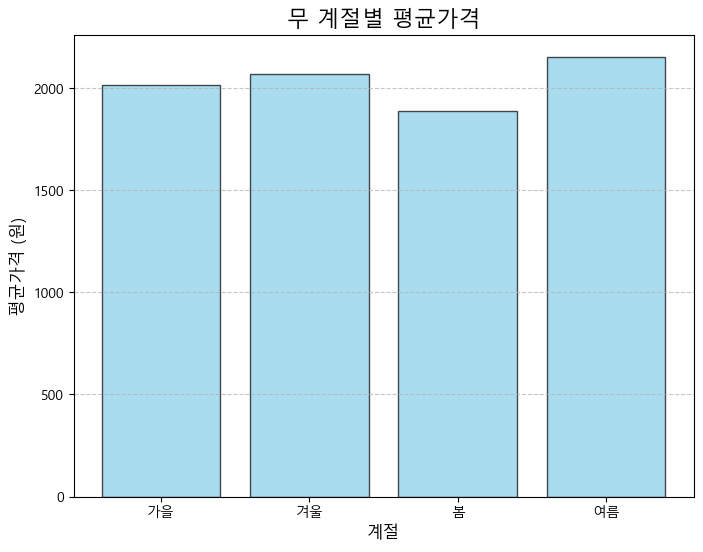

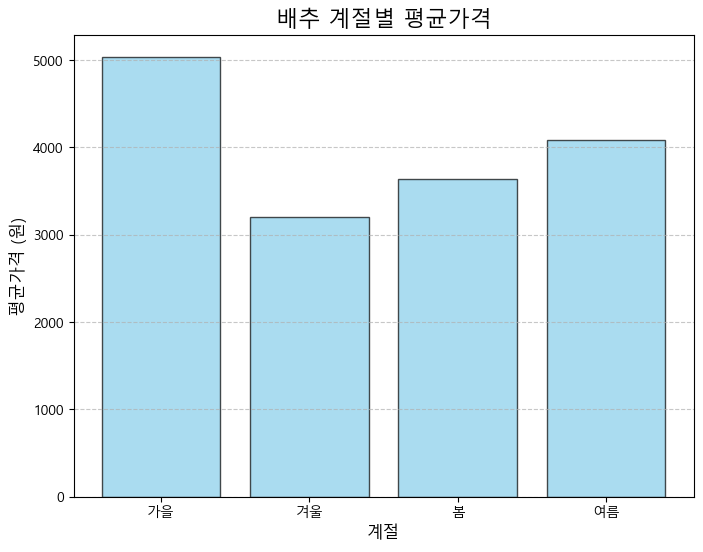

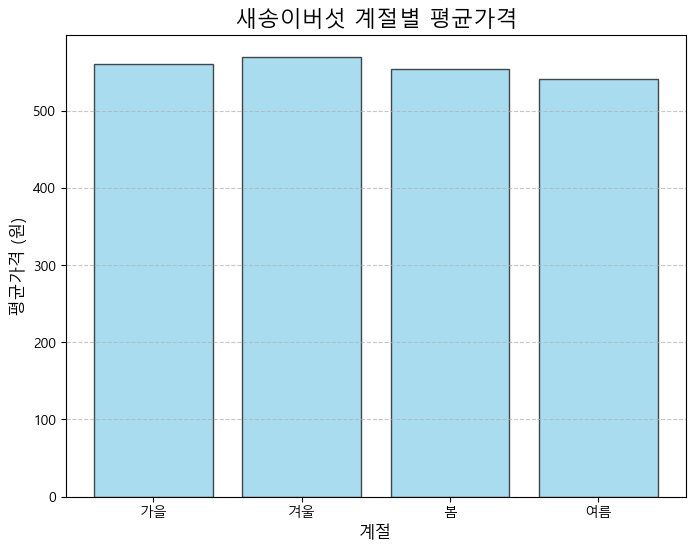

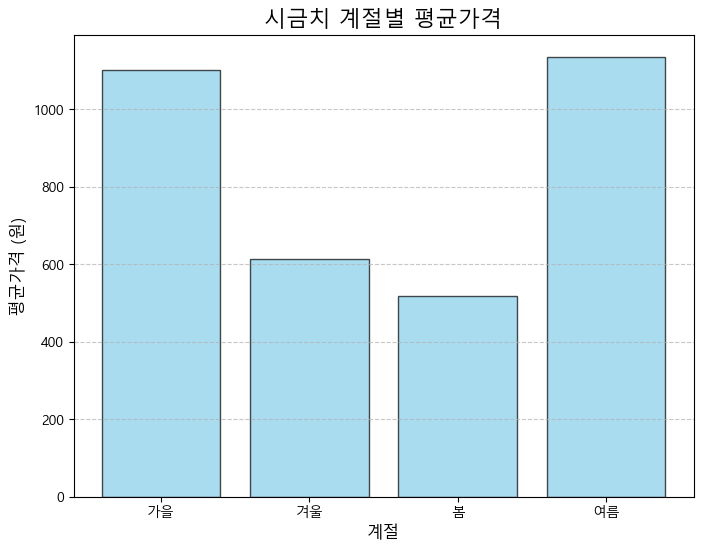

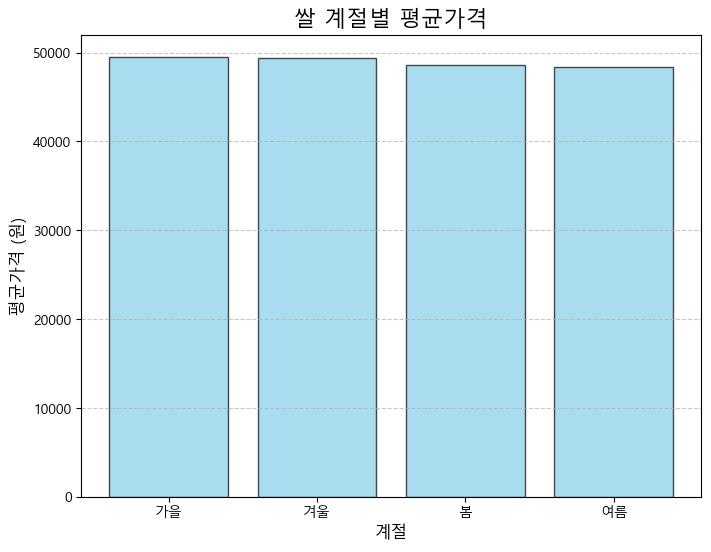

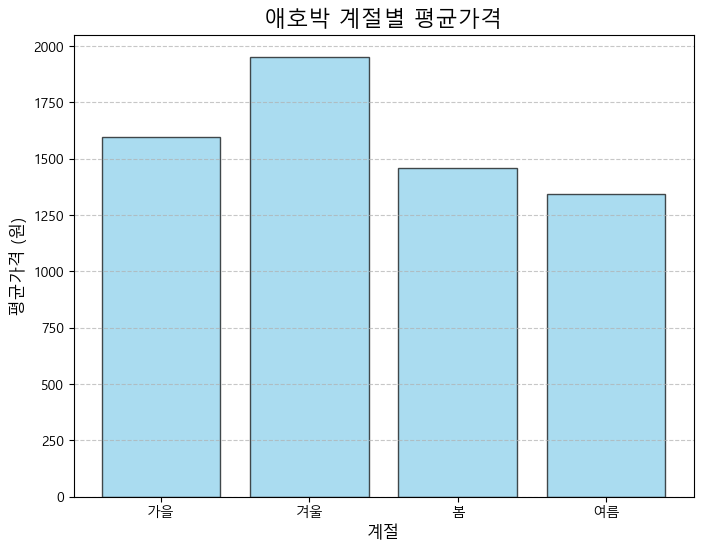

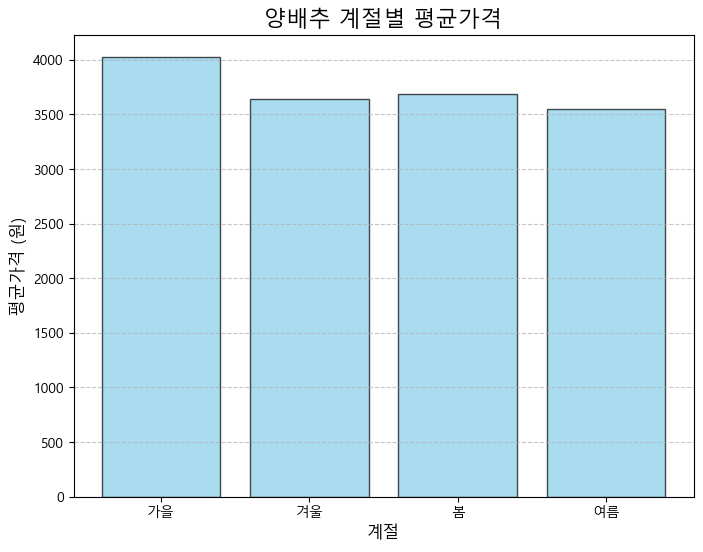

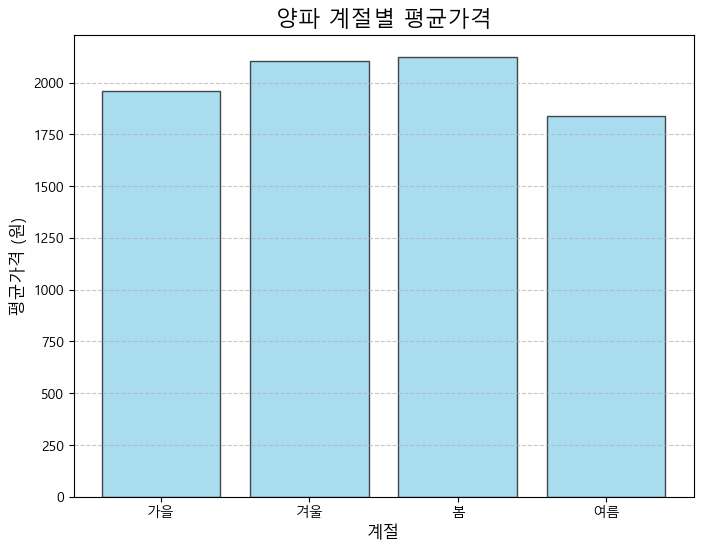

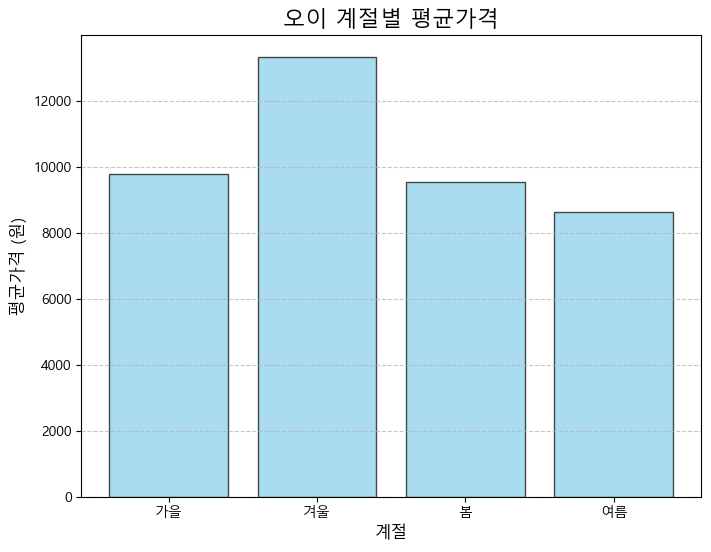

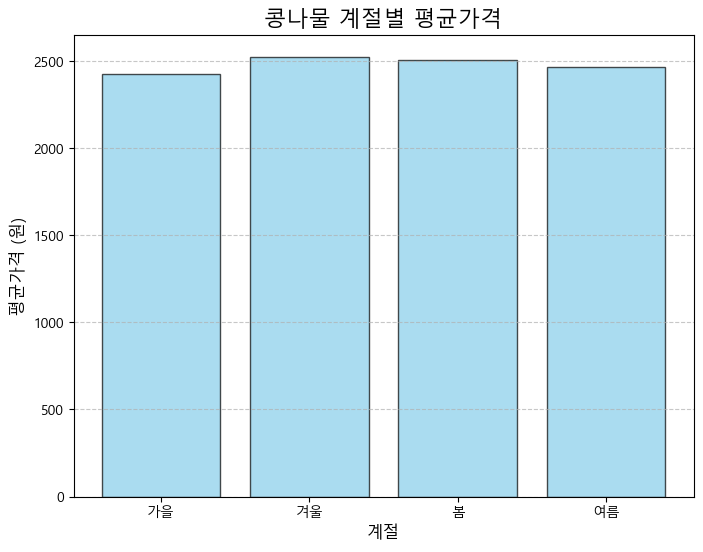

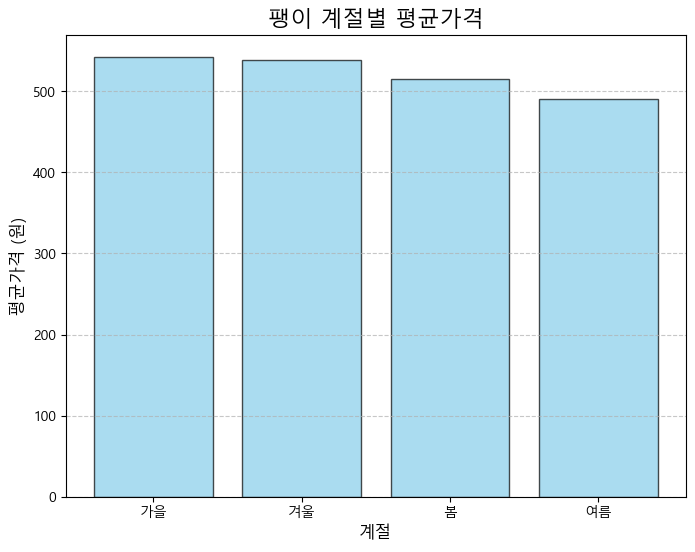

In [3]:
# 계절 분류 함수 정의
def categorize_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:  # 12, 1, 2
        return '겨울'

# '계절' 컬럼 생성
df_가격['계절'] = df_가격['월'].apply(categorize_season)

# 계절별 평균 가격 계산
seasonal_avg_price = df_가격.groupby(['품목명', '계절'])['평균가격'].mean().reset_index()

# 시각화: 계절별 평균 가격
unique_products = df_가격['품목명'].unique()

for product in unique_products:
    product_data = seasonal_avg_price[seasonal_avg_price['품목명'] == product]
    
    plt.figure(figsize=(8, 6))
    plt.bar(product_data['계절'], product_data['평균가격'], color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'{product} 계절별 평균가격', fontsize=16)
    plt.xlabel('계절', fontsize=12)
    plt.ylabel('평균가격 (원)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


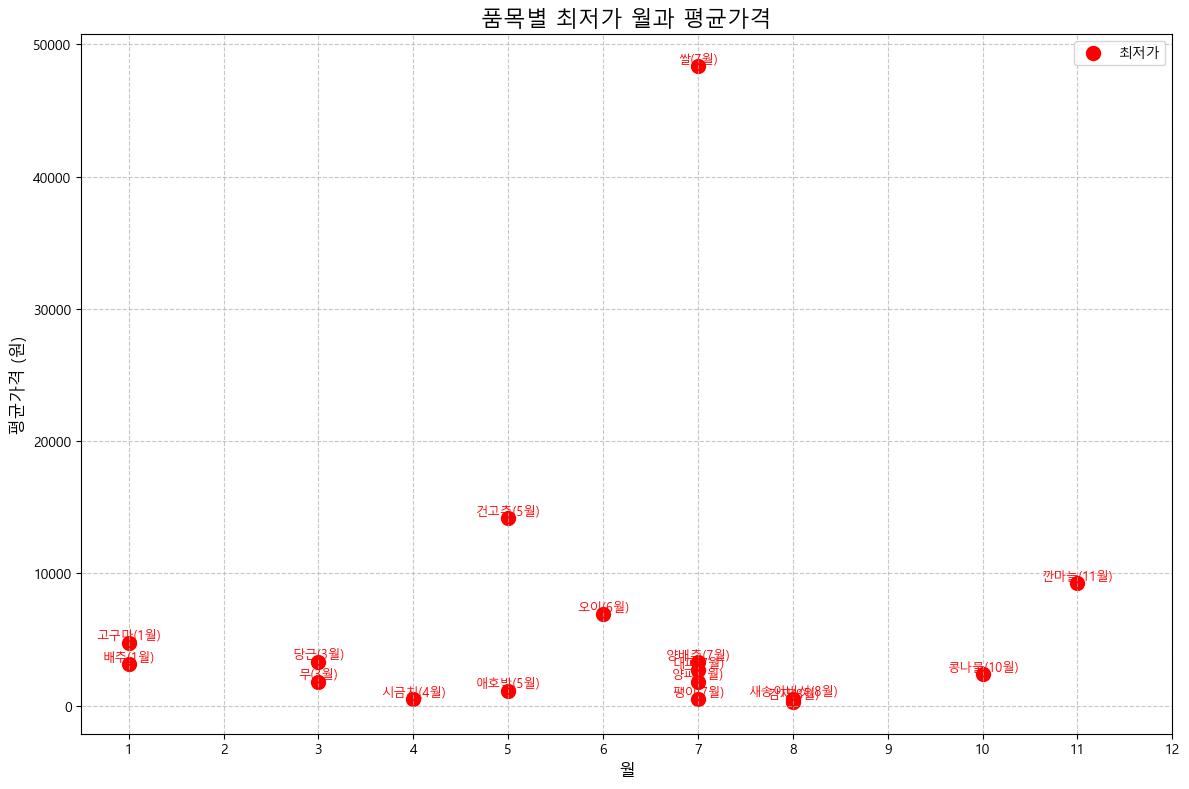

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 읽기
file_path = '품목_소매가_전부.csv'  # 파일 경로에 맞게 수정하세요.
df_가격 = pd.read_csv(file_path, encoding='cp949')

# 데이터 전처리
df_가격.drop(columns=['index'], inplace=True, errors='ignore')  # index 컬럼 제거
df_가격 = df_가격[['구분', '품목', '평균']]  # 필요한 컬럼만 선택
df_가격 = df_가격.rename(columns={'구분': '날짜', '품목': '품목명', '평균': '평균가격'})
df_가격['날짜'] = pd.to_datetime(df_가격['날짜'])  # 날짜 변환
df_가격['평균가격'] = df_가격['평균가격'].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
df_가격['월'] = df_가격['날짜'].dt.month  # 월 컬럼 생성

# 각 품목별 최저가 월 추출
monthly_avg_price = df_가격.groupby(['월', '품목명'])['평균가격'].mean().reset_index()
min_price_per_product = monthly_avg_price.loc[
    monthly_avg_price.groupby('품목명')['평균가격'].idxmin()
]

# 그래프 그리기
plt.figure(figsize=(12, 8))
plt.scatter(min_price_per_product['월'], min_price_per_product['평균가격'], color='red', s=100, label='최저가')

# 최저가 텍스트 추가
for _, row in min_price_per_product.iterrows():
    plt.text(row['월'], row['평균가격'], f"{row['품목명']}({int(row['월'])}월)", fontsize=9, ha='center', va='bottom', color='red')

# 그래프 꾸미기
plt.title('품목별 최저가 월과 평균가격', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균가격 (원)', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


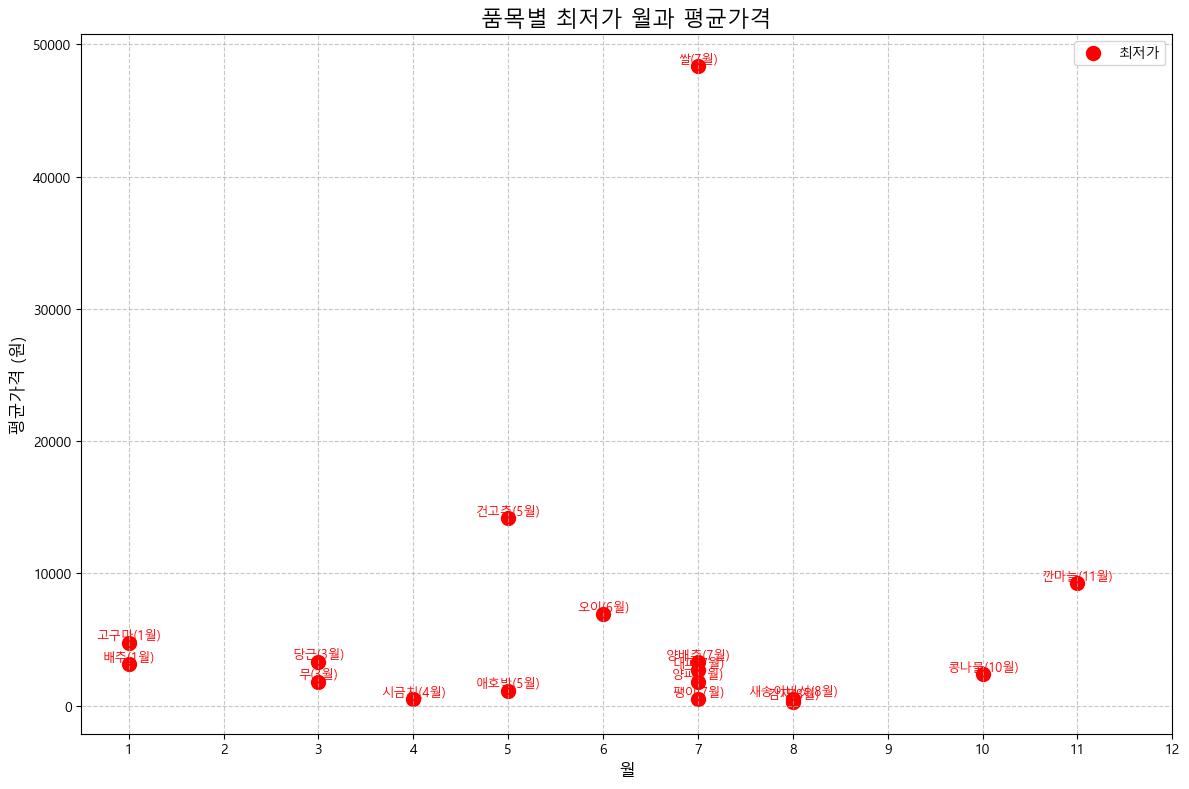

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 읽기
file_path = '품목_소매가_전부.csv'  # 파일 경로에 맞게 수정하세요.
df_가격 = pd.read_csv(file_path, encoding='cp949')

# 데이터 전처리
df_가격.drop(columns=['index'], inplace=True, errors='ignore')  # index 컬럼 제거
df_가격 = df_가격[['구분', '품목', '평균']]  # 필요한 컬럼만 선택
df_가격 = df_가격.rename(columns={'구분': '날짜', '품목': '품목명', '평균': '평균가격'})
df_가격['날짜'] = pd.to_datetime(df_가격['날짜'])  # 날짜 변환
df_가격['평균가격'] = df_가격['평균가격'].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
df_가격['월'] = df_가격['날짜'].dt.month  # 월 컬럼 생성

# 각 품목별 최저가 월 추출
monthly_avg_price = df_가격.groupby(['월', '품목명'])['평균가격'].mean().reset_index()
min_price_per_product = monthly_avg_price.loc[
    monthly_avg_price.groupby('품목명')['평균가격'].idxmin()
]

# 그래프 그리기
plt.figure(figsize=(12, 8))
plt.scatter(min_price_per_product['월'], min_price_per_product['평균가격'], color='red', s=100, label='최저가')

# 최저가 텍스트 추가
for _, row in min_price_per_product.iterrows():
    plt.text(row['월'], row['평균가격'], f"{row['품목명']}({int(row['월'])}월)", fontsize=9, ha='center', va='bottom', color='red')

# 그래프 꾸미기
plt.title('품목별 최저가 월과 평균가격', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균가격 (원)', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [138]:
# 데이터프레임 저장
df.to_pickle("df.pkl")
df.to_csv("df.csv")

In [139]:
# 데이터프레임 불러오기
df_csv = pd.read_csv('C:\\Users\\acorn\\Downloads\\채소사는날\\df.csv')
df_csv

,Unnamed: 0,날짜,품목명,평균가격,단위가격,년월,년,월
0,0,2014-01-02,감자,202.0,2020.0,2014-01,2014,1
1,1,2014-01-03,감자,208.0,2080.0,2014-01,2014,1
2,2,2014-01-04,감자,208.0,2080.0,2014-01,2014,1
3,3,2014-01-05,감자,208.0,2080.0,2014-01,2014,1
4,4,2014-01-06,감자,281.0,2810.0,2014-01,2014,1
...,...,...,...,...,...,...,...,...
65115,65115,2024-12-01,팽이,529.0,529.0,2024-12,2024,12
65116,65116,2024-12-02,팽이,529.0,529.0,2024-12,2024,12
65117,65117,2024-12-03,팽이,530.0,530.0,2024-12,2024,12
65118,65118,2024-12-04,팽이,534.0,534.0,2024-12,2024,12


In [140]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65120 entries, 0 to 65119
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  65120 non-null  int64  
 1   날짜          65120 non-null  object 
 2   품목명         65120 non-null  object 
 3   평균가격        65120 non-null  float64
 4   단위가격        65120 non-null  float64
 5   년월          65120 non-null  object 
 6   년           65120 non-null  int64  
 7   월           65120 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 4.0+ MB


# 계절별 평균가격이 최저가인 품목

In [259]:
def get_season(month):
    """
    월을 계절로 바꾸는 함수
    3,4,5월 -> 봄
    6,7,8월 -> 여름
    9,10,11월 -> 가을
    11,1,2월 -> 겨울
    """
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'


In [257]:
# '품목명'별로 '단위가격' 평균값이 최저인 월 구하기
monthly_minprice_df = (
    df.groupby(['품목명', '월'])['단위가격']
    .mean()
    .reset_index()
    .sort_values(['품목명', '단위가격']) # 오른차순 하고
    .drop_duplicates('품목명', keep='first') # 첫번째만 남기므로 가장 작은 값?
)

# 계절별로 품목 분류
monthly_minprice_df['계절'] = monthly_minprice_df['월'].apply(get_season)
seasons = monthly_minprice_df.groupby('계절')['품목명'].apply(list).to_dict()
print('\n계절별 최저가 품목\n',
      seasons)
print('\n품목명별로 단위가격 평균값이 최저인 월\n',
      monthly_minprice_df.sort_values('월')
     )


# 데이터프레임 저장
monthly_minprice_df.to_csv("monthly_minprice_df.csv")


계절별 최저가 품목
 {'가을': ['깐마늘', '콩나물'], '겨울': ['고구마', '배추'], '봄': ['건고추', '당근', '무', '시금치', '애호박'], '여름': ['감자', '대파', '새송이버섯', '쌀', '양배추', '양파', '오이', '팽이']}

품목명별로 단위가격 평균값이 최저인 월
        품목명   월          단위가격  계절
24     고구마   1   4754.623529  겨울
84      배추   1    936.712059  겨울
50      당근   3   3307.821114   봄
74       무   3   1815.000000   봄
111    시금치   4   4903.181818   봄
16     건고추   5  23623.367546   봄
136    애호박   5   1133.844575   봄
173     오이   6   3457.583333  여름
198     팽이   7    485.108504  여름
66      대파   7   2674.431085  여름
162     양파   7   1824.436950  여름
126      쌀   7   2417.738710  여름
150    양배추   7   2968.840309  여름
7       감자   8   2803.753666  여름
103  새송이버섯   8    537.099707  여름
189    콩나물  10   2388.967742  가을
46     깐마늘  11   9271.563863  가을


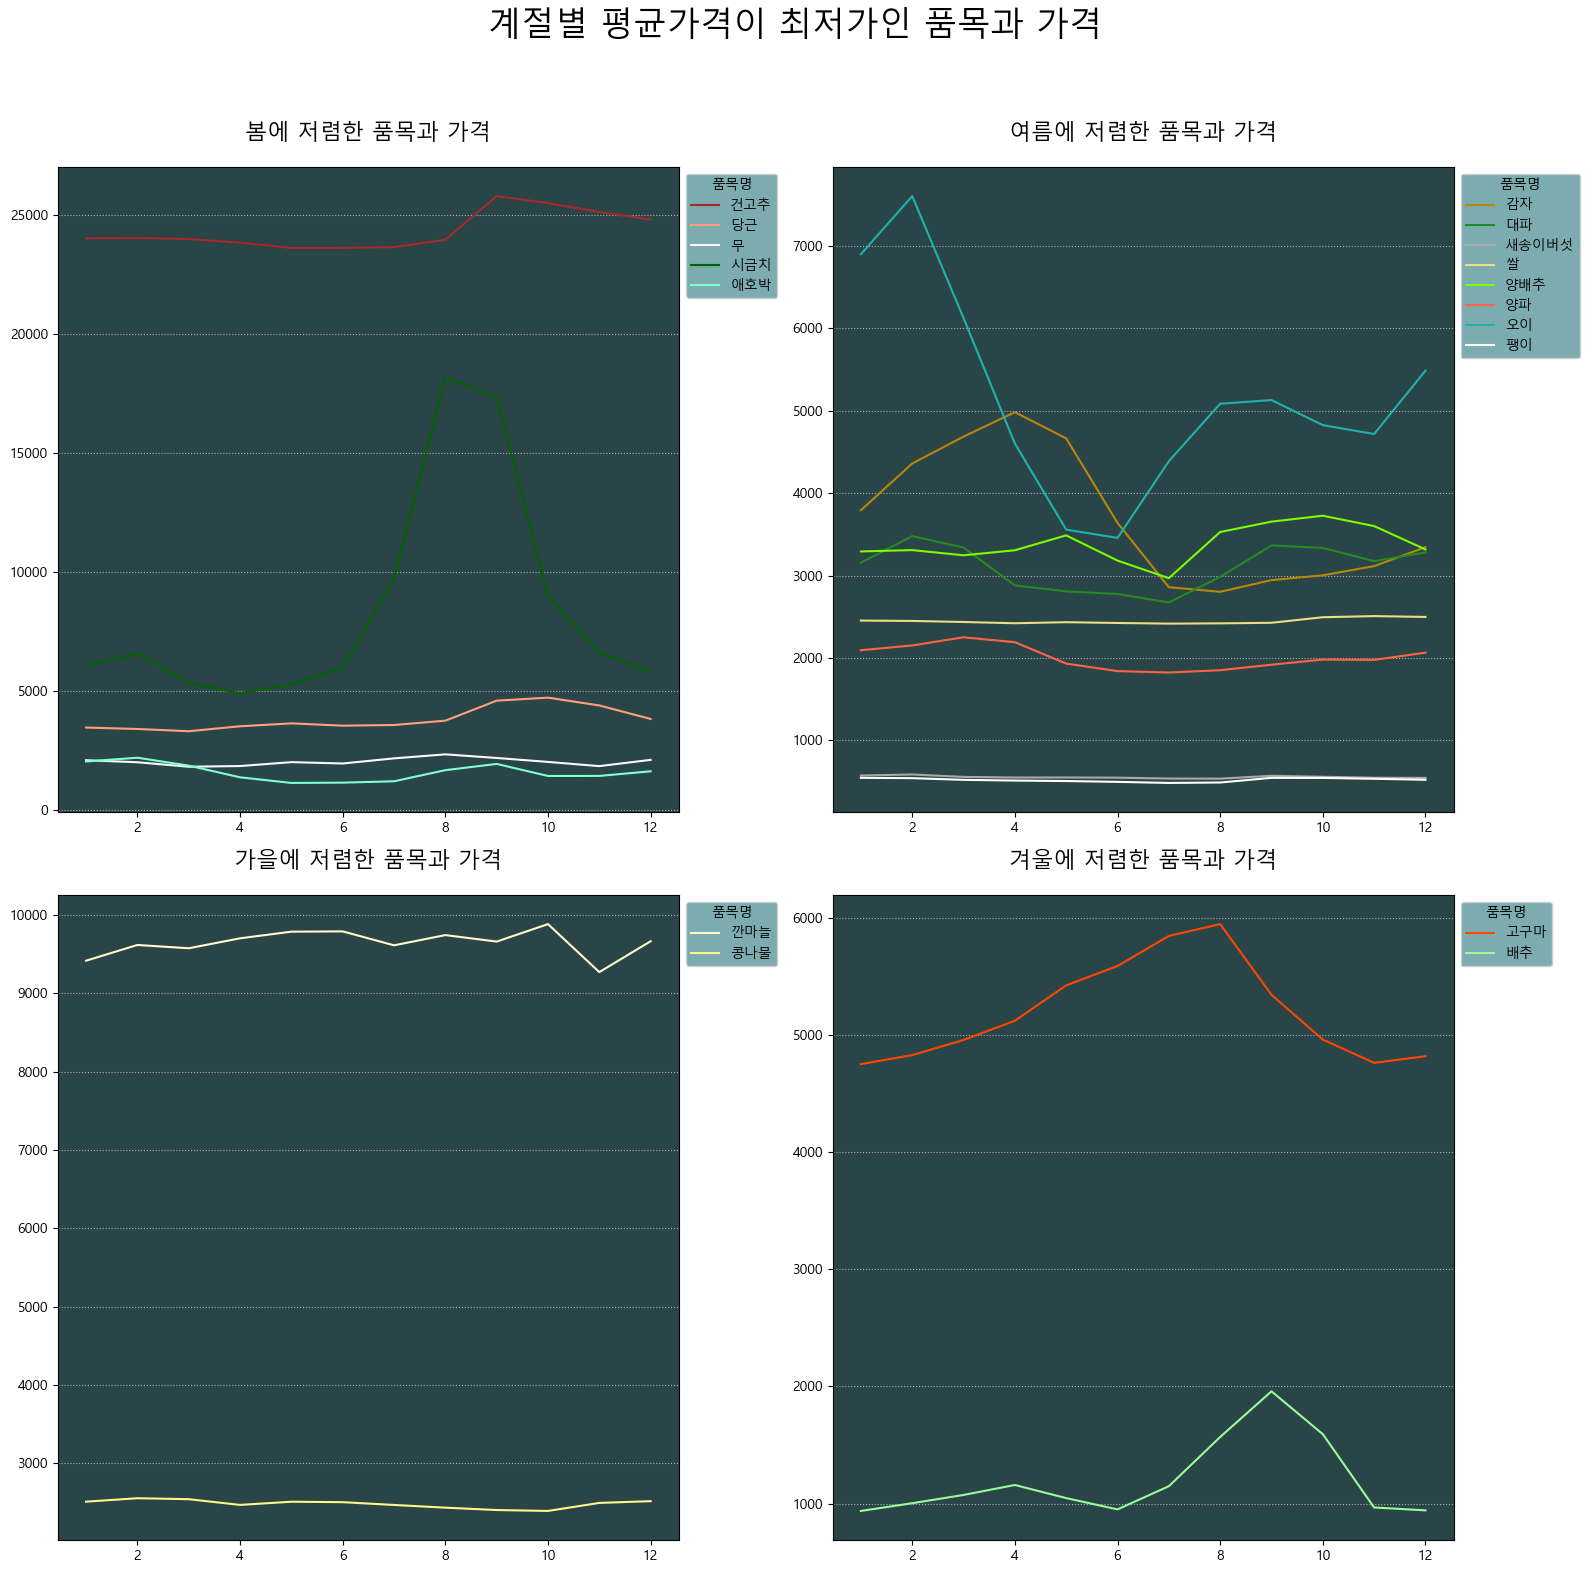

In [269]:
# 품목명과 색상을 매핑하는 딕셔너리 생성
품목명_list = list(df['품목명'].unique())
color_mapping = {
    '감자': '#b8860b',        # 감자의 금빛 갈색
    '건고추': '#a52a2a',      # 건고추의 깊은 적갈색
    '고구마': '#ff4500',      # 고구마의 선명한 주황색
    '깐마늘': '#fffacd',      # 마늘 속살의 연노란색
    '당근': '#ffa07a',        # 당근의 연한 주황색
    '대파': '#228b22',        # 대파의 짙은 녹색
    '무': '#f8f8ff',          # 무의 깨끗한 흰색
    '배추': '#98fb98',        # 배추의 옅은 연녹색
    '새송이버섯': '#a9a9a9',  # 새송이버섯의 중간 회색
    '시금치': '#006400',      # 시금치의 짙은 녹색
    '쌀': '#eedd82',          # 쌀의 밝은 금빛 베이지색
    '애호박': '#7fffd4',      # 애호박의 밝은 청록색
    '양배추': '#7cfc00',      # 양배추의 선명한 연두색
    '양파': '#ff6347',        # 양파의 붉은 황색
    '오이': '#20b2aa',        # 오이의 선명한 청록색
    '콩나물': '#fff68f',      # 콩나물의 부드러운 노란색
    '팽이': '#ffffff'         # 팽이버섯의 순백색
}
bar_colors = [color_mapping.get(item) for item in 품목명_list]


# 그래프 생성
fig = plt.figure(figsize=(16, 16))

# 계절별 그래프 위치 설정
subplot_positions = {
    '봄': 221,
    '여름': 222,
    '가을': 223,
    '겨울': 224
}

# 각 계절별 품목의 월별 평균 단위가격 추이 플롯
for season, pos in subplot_positions.items():
    ax = plt.subplot(pos)  # Subplot 객체 생성
    ax.set_facecolor('#2a4548')  # 서브플롯의 배경색 설정
    
    if season in seasons:
        for item in seasons[season]:
            x = df[df['품목명'] == item].groupby('월').agg(평균=('단위가격', 'mean')).index
            y = df[df['품목명'] == item].groupby('월').agg(평균=('단위가격', 'mean'))['평균']
            
            # 해당 품목의 색상 추출
            item_color = color_mapping.get(item, '#000000')  # 기본값은 검정색
            
            # 품목별 라인 플롯
            plt.plot(x, y, color=item_color, label=item)
            plt.grid(axis='y', ls=':')
        
        # 범례 설정
        legend = plt.legend(title="품목명", bbox_to_anchor=(1, 1), loc='upper left')
        legend.get_frame().set_facecolor('#5c979d')  # 범례의 배경색 설정
    
    # 제목 설정
    plt.title(f'{season}에 저렴한 품목과 가격', fontsize=16, pad=20)

# 전체 그래프 제목 및 레이아웃 설정
fig.suptitle('계절별 평균가격이 최저가인 품목과 가격', size=24)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# 그래프 저장 및 출력
plt.savefig('계절별 평균가격이 최저가인 품목과 가격.png', dpi=200)
plt.show()

# 월별 평균가격 편차 품목 그래프

In [204]:
def get_price_diff_rate(df, period, items):
    """
    df 데이터프레임을 period(년 or 월)별 평균 냈을 때 item(품목)별로 가격 편차를 구하기
    Parameters:
    - df : DataFrame
    - period : 그룹화할 기간 (예: '년', '월', '분기' 등)
    - items : 품목명 리스트

    Returns:
    - DataFrame : 품목명과 가격편차가 포함된 데이터프레임
    """
    data = []
    for item in items:
        # 품목별 데이터 필터링
        filtered_df = df[df['품목명'] == item]

        # 기간별 평균 단위가격 계산
        grouped = filtered_df.groupby(period).agg(평균=('단위가격', 'mean'))

        # 최소, 최대, 전체 평균 계산
        monthly_min = grouped['평균'].min()
        monthly_max = grouped['평균'].max()
        all_mean = filtered_df['단위가격'].mean()

        # 가격 편차율 계산
        price_diff_rate = (monthly_max - monthly_min) / all_mean if all_mean != 0 else 0

        # 결과 저장
        data.append({'품목명': item, '가격편차': price_diff_rate})

    # 결과를 데이터프레임으로 반환
    return pd.DataFrame(data)


In [260]:
# 월별 평균가격 편차 구하기
df_monthly_price_diff_rate = get_price_diff_rate(df, '월', list(df['품목명'].unique()))

# 정렬 및 정리
df_monthly_price_diff_rate.sort_values('가격편차', ascending=False, inplace=True)

print('\n월별 평균가격 편차 품목 내림차순\n', 
      df_monthly_price_diff_rate
     )
print('\n월별 평균가격 편차 50% 이상인 품목\n', 
      df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] >= 0.5].sort_values('가격편차', ascending = False)
     )
print('\n월별 평균가격 편차 10% 이하인 품목\n', 
      df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] <= 0.1].sort_values('가격편차', ascending = False)
     )

# 데이터프레임 저장
df_monthly_price_diff_rate.to_csv("df_monthly_price_diff_rate.csv")


월별 평균가격 편차 품목 내림차순
       품목명      가격편차
9     시금치  1.577224
7      배추  0.853119
14     오이  0.805975
11    애호박  0.669771
0      감자  0.591697
4      당근  0.370704
5      대파  0.259481
6       무  0.256222
2     고구마  0.229772
12    양배추  0.223823
13     양파  0.213021
16     팽이  0.118532
8   새송이버섯  0.091141
1     건고추  0.089495
15    콩나물  0.065480
3     깐마늘  0.063556
10      쌀  0.037207

월별 평균가격 편차 50% 이상인 품목
     품목명      가격편차
9   시금치  1.577224
7    배추  0.853119
14   오이  0.805975
11  애호박  0.669771
0    감자  0.591697

월별 평균가격 편차 10% 이하인 품목
       품목명      가격편차
8   새송이버섯  0.091141
1     건고추  0.089495
15    콩나물  0.065480
3     깐마늘  0.063556
10      쌀  0.037207


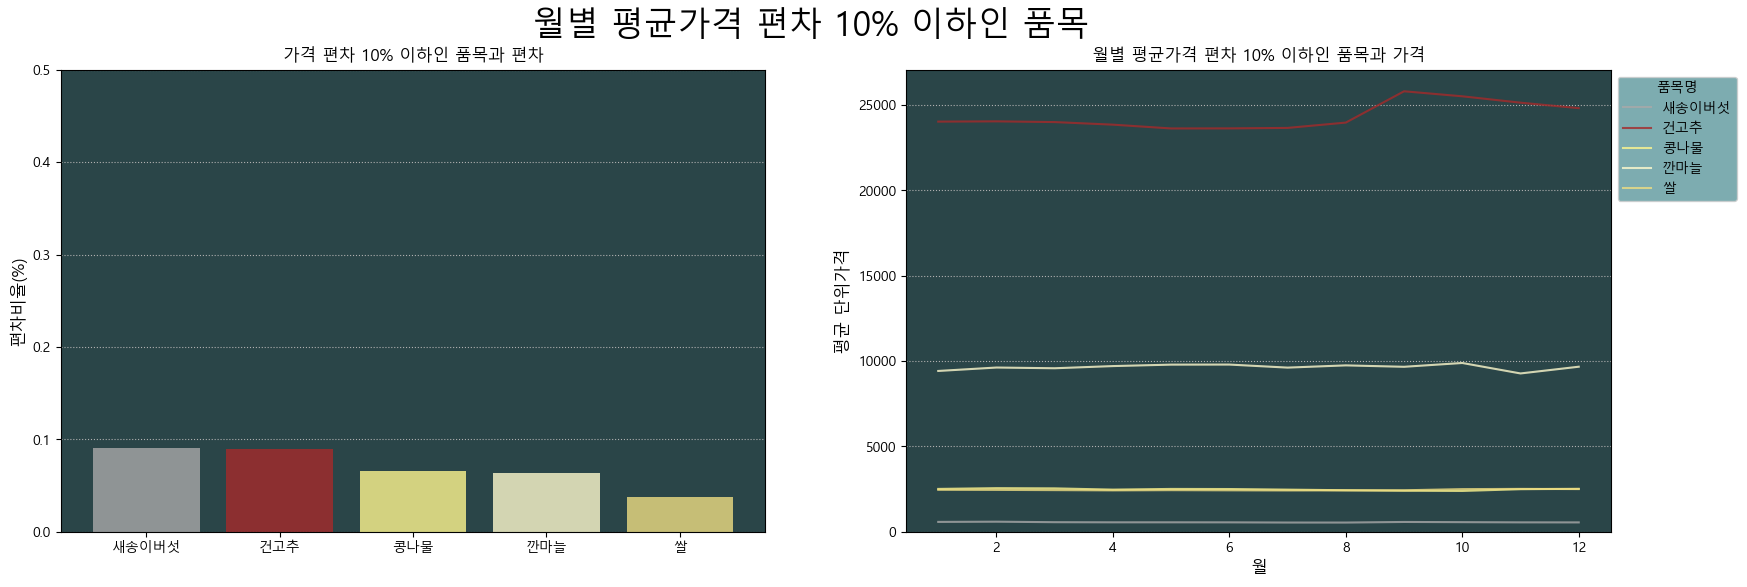

In [273]:
# 품목명과 색상을 매핑하는 딕셔너리 생성
품목명_list = list(df['품목명'].unique())
color_mapping = {
    '감자': '#b8860b',        # 감자의 금빛 갈색
    '건고추': '#a52a2a',      # 건고추의 깊은 적갈색
    '고구마': '#ff4500',      # 고구마의 선명한 주황색
    '깐마늘': '#fffacd',      # 마늘 속살의 연노란색
    '당근': '#ffa07a',        # 당근의 연한 주황색
    '대파': '#228b22',        # 대파의 짙은 녹색
    '무': '#f8f8ff',          # 무의 깨끗한 흰색
    '배추': '#98fb98',        # 배추의 옅은 연녹색
    '새송이버섯': '#a9a9a9',  # 새송이버섯의 중간 회색
    '시금치': '#006400',      # 시금치의 짙은 녹색
    '쌀': '#eedd82',          # 쌀의 밝은 금빛 베이지색
    '애호박': '#7fffd4',      # 애호박의 밝은 청록색
    '양배추': '#7cfc00',      # 양배추의 선명한 연두색
    '양파': '#ff6347',        # 양파의 붉은 황색
    '오이': '#20b2aa',        # 오이의 선명한 청록색
    '콩나물': '#fff68f',      # 콩나물의 부드러운 노란색
    '팽이': '#ffffff'         # 팽이버섯의 순백색
}
bar_colors = [color_mapping.get(item) for item in 품목명_list]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# ax[0]
x0 = df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] <= 0.1].sort_values('가격편차', ascending=False)['품목명']
y0 = df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] <= 0.1].sort_values('가격편차', ascending=False)['가격편차']
x0_colors = [color_mapping[item] for item in x0]  # x0에 해당하는 품목명별 색상 생성
ax[0].bar(x0, y0, color=x0_colors, alpha=0.8)

ax[0].set_facecolor('#2a4548')
# ax[0].set_ylim(0, 1.1)
ax[0].set_yticks(np.arange(0, 0.6, step=0.1))
ax[0].grid(axis='y', ls=':')
ax[0].set_ylabel('편차비율(%)', fontsize=12)
ax[0].set_title('가격 편차 10% 이하인 품목과 편차')

# ax[1]
품목_list = df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] <= 0.1, '품목명'].unique()

for item in 품목_list:
    # 월별 평균 계산
    x = df[df['품목명'] == item].groupby('월').agg(평균=('단위가격', 'mean')).index
    y = df[df['품목명'] == item].groupby('월').agg(평균=('단위가격', 'mean'))['평균']
    
    # 데이터 플롯
    ax[1].plot(x, y, color=color_mapping[item], alpha=0.8, label=item)

ax[1].set_facecolor('#2a4548')
ax[1].grid(axis='y', ls=':')
ax[1].set_xlabel('월', fontsize=12)
ax[1].set_ylabel('평균 단위가격', fontsize=12)
ax[1].set_ylim(0)
ax[1].set_title('월별 평균가격 편차 10% 이하인 품목과 가격')
ax[1].legend(title="품목명", bbox_to_anchor=(1, 1), loc='upper left', facecolor='#5c979d')

# 제목 및 저장
fig.suptitle('월별 평균가격 편차 10% 이하인 품목', fontsize=24)
fig.savefig('월별 평균가격 편차 10% 이하인 품목.png', dpi=200)
plt.show()

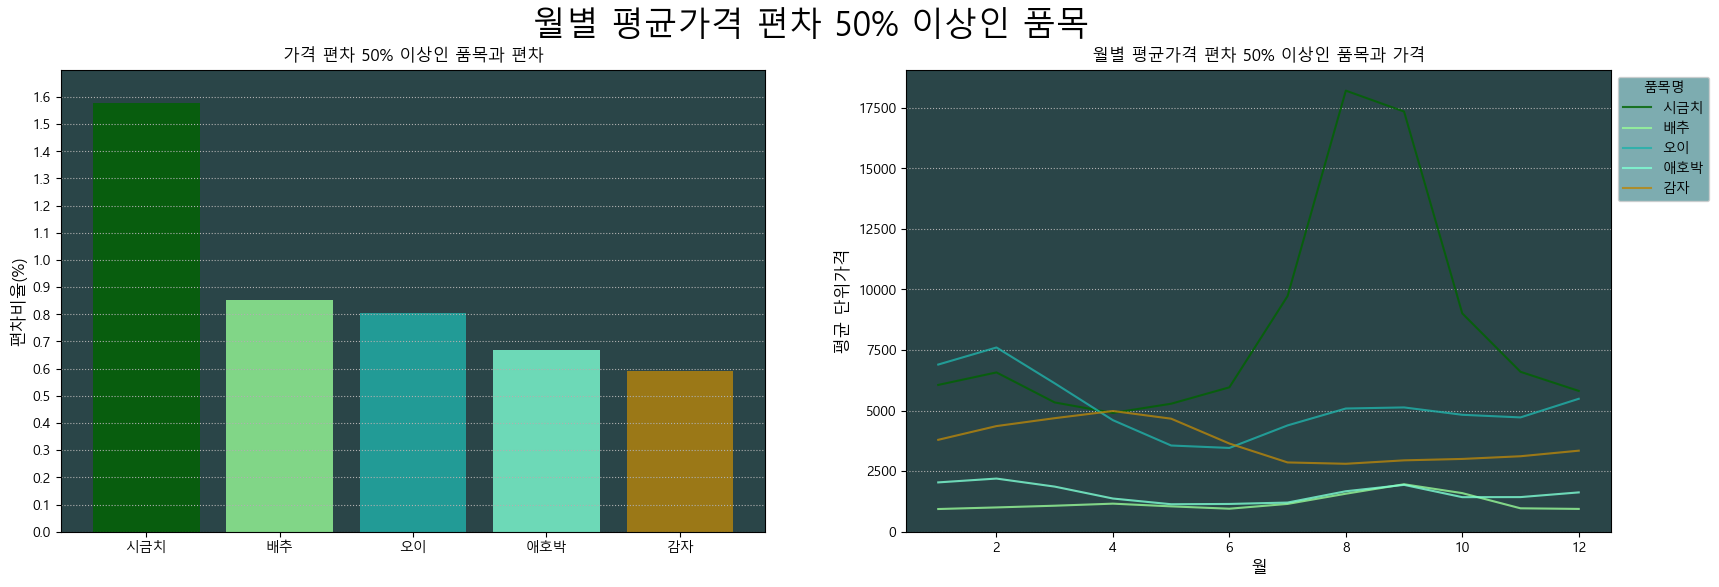

In [274]:
# 품목명과 색상을 매핑하는 딕셔너리 생성
품목명_list = list(df['품목명'].unique())
color_mapping = {
    '감자': '#b8860b',        # 감자의 금빛 갈색
    '건고추': '#a52a2a',      # 건고추의 깊은 적갈색
    '고구마': '#ff4500',      # 고구마의 선명한 주황색
    '깐마늘': '#fffacd',      # 마늘 속살의 연노란색
    '당근': '#ffa07a',        # 당근의 연한 주황색
    '대파': '#228b22',        # 대파의 짙은 녹색
    '무': '#f8f8ff',          # 무의 깨끗한 흰색
    '배추': '#98fb98',        # 배추의 옅은 연녹색
    '새송이버섯': '#a9a9a9',  # 새송이버섯의 중간 회색
    '시금치': '#006400',      # 시금치의 짙은 녹색
    '쌀': '#eedd82',          # 쌀의 밝은 금빛 베이지색
    '애호박': '#7fffd4',      # 애호박의 밝은 청록색
    '양배추': '#7cfc00',      # 양배추의 선명한 연두색
    '양파': '#ff6347',        # 양파의 붉은 황색
    '오이': '#20b2aa',        # 오이의 선명한 청록색
    '콩나물': '#fff68f',      # 콩나물의 부드러운 노란색
    '팽이': '#ffffff'         # 팽이버섯의 순백색
}
bar_colors = [color_mapping.get(item) for item in 품목명_list]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# ax[0]
x0 = df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] >= 0.5].sort_values('가격편차', ascending=False)['품목명']
y0 = df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] >= 0.5].sort_values('가격편차', ascending=False)['가격편차']
x0_colors = [color_mapping[item] for item in x0]  # x0에 해당하는 품목명별 색상 생성
ax[0].bar(x0, y0, color=x0_colors, alpha=0.8)

ax[0].set_facecolor('#2a4548')
ax[0].set_ylim(0, 1.7)
ax[0].set_yticks(np.arange(0, 1.7, step=0.1))
ax[0].grid(axis='y', ls=':')
ax[0].set_ylabel('편차비율(%)', fontsize=12)
ax[0].set_title('가격 편차 50% 이상인 품목과 편차')

# ax[1]
품목_list = df_monthly_price_diff_rate.loc[df_monthly_price_diff_rate['가격편차'] >= 0.5, '품목명'].unique()

for item in 품목_list:
    # 월별 평균 계산
    x = df[df['품목명'] == item].groupby('월').agg(평균=('단위가격', 'mean')).index
    y = df[df['품목명'] == item].groupby('월').agg(평균=('단위가격', 'mean'))['평균']
    
    # 데이터 플롯
    ax[1].plot(x, y, color=color_mapping[item], alpha=0.8, label=item)

ax[1].set_facecolor('#2a4548')
ax[1].grid(axis='y', ls=':')
ax[1].set_xlabel('월', fontsize=12)
ax[1].set_ylabel('평균 단위가격', fontsize=12)
ax[1].set_ylim(0)
ax[1].set_title('월별 평균가격 편차 50% 이상인 품목과 가격')
ax[1].legend(title="품목명", bbox_to_anchor=(1, 1), loc='upper left', facecolor='#5c979d')

# 제목 및 저장
fig.suptitle('월별 평균가격 편차 50% 이상인 품목', fontsize=24)
fig.savefig('월별 평균가격 편차 50% 이상인 품목.png', dpi=200)
plt.show()

# 연도별 평균가격 편차 품목 그래프

In [261]:
# 연도별 평균가격 편차 구하기
df_yearly_price_diff_rate = get_price_diff_rate(df, '년', list(df['품목명'].unique()))

# 정렬 및 정리
df_yearly_price_diff_rate.sort_values('가격편차', ascending=False, inplace=True)

print('\n연도별 평균가격 편차 품목 내림차순\n', 
      df_yearly_price_diff_rate
     )
print('\연도별 평균가격 편차 50% 이상인 품목\n', 
      df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] >= 0.5].sort_values('가격편차', ascending = False)
     )
print('\연도별 평균가격 편차 10% 이하인 품목\n', 
      df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] <= 0.1].sort_values('가격편차', ascending = False)
     )

# 데이터프레임 저장
df_yearly_price_diff_rate.to_csv("df_yearly_price_diff_rate.csv")


월별 평균가격 편차 품목 내림차순
       품목명      가격편차
9     시금치  1.173202
4      당근  0.773653
7      배추  0.745246
14     오이  0.735461
12    양배추  0.711037
3     깐마늘  0.654142
5      대파  0.611642
0      감자  0.608585
1     건고추  0.602126
13     양파  0.469041
10      쌀  0.440405
11    애호박  0.395736
2     고구마  0.356122
6       무  0.331887
16     팽이  0.233246
8   새송이버섯  0.169010
15    콩나물  0.053068

월별 평균가격 편차 50% 이상인 품목
     품목명      가격편차
9   시금치  1.173202
4    당근  0.773653
7    배추  0.745246
14   오이  0.735461
12  양배추  0.711037
3   깐마늘  0.654142
5    대파  0.611642
0    감자  0.608585
1   건고추  0.602126

월별 평균가격 편차 10% 이하인 품목
     품목명      가격편차
15  콩나물  0.053068


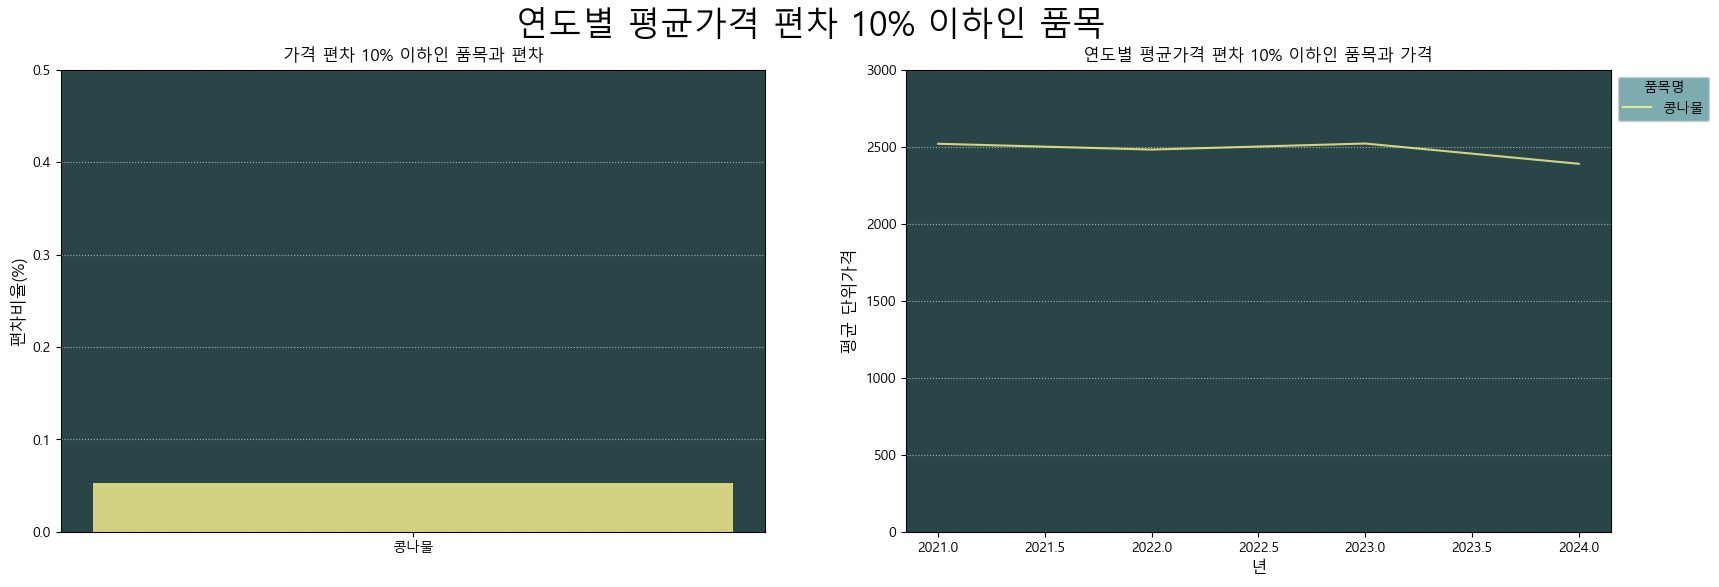

In [275]:
# 품목명과 색상을 매핑하는 딕셔너리 생성
품목명_list = list(df['품목명'].unique())
color_mapping = {
    '감자': '#b8860b',        # 감자의 금빛 갈색
    '건고추': '#a52a2a',      # 건고추의 깊은 적갈색
    '고구마': '#ff4500',      # 고구마의 선명한 주황색
    '깐마늘': '#fffacd',      # 마늘 속살의 연노란색
    '당근': '#ffa07a',        # 당근의 연한 주황색
    '대파': '#228b22',        # 대파의 짙은 녹색
    '무': '#f8f8ff',          # 무의 깨끗한 흰색
    '배추': '#98fb98',        # 배추의 옅은 연녹색
    '새송이버섯': '#a9a9a9',  # 새송이버섯의 중간 회색
    '시금치': '#006400',      # 시금치의 짙은 녹색
    '쌀': '#eedd82',          # 쌀의 밝은 금빛 베이지색
    '애호박': '#7fffd4',      # 애호박의 밝은 청록색
    '양배추': '#7cfc00',      # 양배추의 선명한 연두색
    '양파': '#ff6347',        # 양파의 붉은 황색
    '오이': '#20b2aa',        # 오이의 선명한 청록색
    '콩나물': '#fff68f',      # 콩나물의 부드러운 노란색
    '팽이': '#ffffff'         # 팽이버섯의 순백색
}
bar_colors = [color_mapping.get(item) for item in 품목명_list]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# ax[0]
x0 = df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] <= 0.1].sort_values('가격편차', ascending=False)['품목명']
y0 = df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] <= 0.1].sort_values('가격편차', ascending=False)['가격편차']
x0_colors = [color_mapping[item] for item in x0]  # x0에 해당하는 품목명별 색상 생성
ax[0].bar(x0, y0, color=x0_colors, alpha=0.8)

ax[0].set_facecolor('#2a4548')
# ax[0].set_ylim(0, 1.1)
ax[0].set_yticks(np.arange(0, 0.6, step=0.1))
ax[0].grid(axis='y', ls=':')
ax[0].set_ylabel('편차비율(%)', fontsize=12)
ax[0].set_title('가격 편차 10% 이하인 품목과 편차')

# ax[1]
품목_list = df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] <= 0.1, '품목명'].unique()

for item in 품목_list:
    # 월별 평균 계산
    x = df[df['품목명'] == item].groupby('년').agg(평균=('단위가격', 'mean')).index
    y = df[df['품목명'] == item].groupby('년').agg(평균=('단위가격', 'mean'))['평균']
    
    # 데이터 플롯
    ax[1].plot(x, y, color=color_mapping[item], alpha=0.8, label=item)

ax[1].set_facecolor('#2a4548')
ax[1].grid(axis='y', ls=':')
ax[1].set_xlabel('년', fontsize=12)
ax[1].set_ylabel('평균 단위가격', fontsize=12)
ax[1].set_ylim(0, 3000)
ax[1].set_title('연도별 평균가격 편차 10% 이하인 품목과 가격')
ax[1].legend(title="품목명", bbox_to_anchor=(1, 1), loc='upper left', facecolor='#5c979d')

# 제목 및 저장
fig.suptitle('연도별 평균가격 편차 10% 이하인 품목', fontsize=24)
fig.savefig('연도별 평균가격 편차 10% 이하인 품목.png', dpi=200)
plt.show()

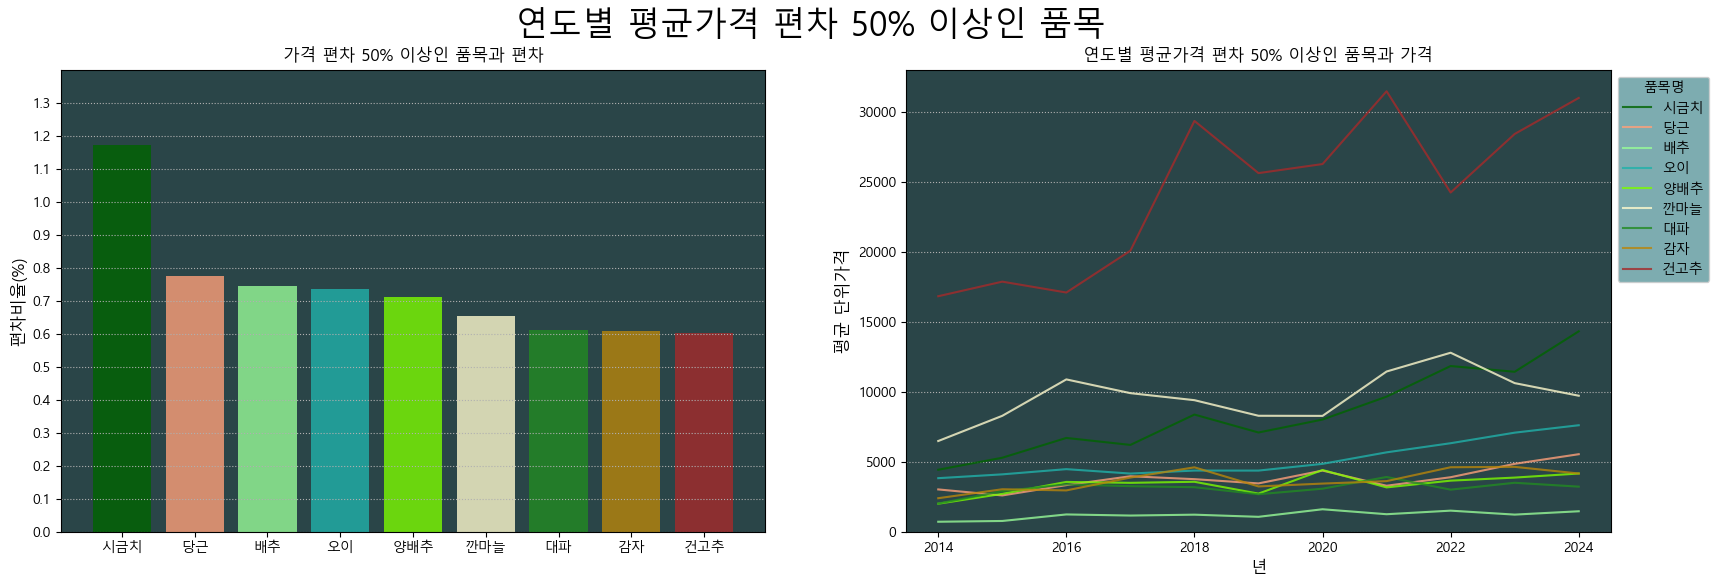

In [276]:
# 품목명과 색상을 매핑하는 딕셔너리 생성
품목명_list = list(df['품목명'].unique())
color_mapping = {
    '감자': '#b8860b',        # 감자의 금빛 갈색
    '건고추': '#a52a2a',      # 건고추의 깊은 적갈색
    '고구마': '#ff4500',      # 고구마의 선명한 주황색
    '깐마늘': '#fffacd',      # 마늘 속살의 연노란색
    '당근': '#ffa07a',        # 당근의 연한 주황색
    '대파': '#228b22',        # 대파의 짙은 녹색
    '무': '#f8f8ff',          # 무의 깨끗한 흰색
    '배추': '#98fb98',        # 배추의 옅은 연녹색
    '새송이버섯': '#a9a9a9',  # 새송이버섯의 중간 회색
    '시금치': '#006400',      # 시금치의 짙은 녹색
    '쌀': '#eedd82',          # 쌀의 밝은 금빛 베이지색
    '애호박': '#7fffd4',      # 애호박의 밝은 청록색
    '양배추': '#7cfc00',      # 양배추의 선명한 연두색
    '양파': '#ff6347',        # 양파의 붉은 황색
    '오이': '#20b2aa',        # 오이의 선명한 청록색
    '콩나물': '#fff68f',      # 콩나물의 부드러운 노란색
    '팽이': '#ffffff'         # 팽이버섯의 순백색
}
bar_colors = [color_mapping.get(item) for item in 품목명_list]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# ax[0]
x0 = df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] >= 0.5].sort_values('가격편차', ascending=False)['품목명']
y0 = df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] >= 0.5].sort_values('가격편차', ascending=False)['가격편차']
x0_colors = [color_mapping[item] for item in x0]  # x0에 해당하는 품목명별 색상 생성
ax[0].bar(x0, y0, color=x0_colors, alpha=0.8)

ax[0].set_facecolor('#2a4548')
ax[0].set_ylim(0, 1.4)
ax[0].set_yticks(np.arange(0, 1.4, step=0.1))
ax[0].grid(axis='y', ls=':')
ax[0].set_ylabel('편차비율(%)', fontsize=12)
ax[0].set_title('가격 편차 50% 이상인 품목과 편차')

# ax[1]
품목_list = df_yearly_price_diff_rate.loc[df_yearly_price_diff_rate['가격편차'] >= 0.5, '품목명'].unique()

for item in 품목_list:
    # 월별 평균 계산
    x = df[df['품목명'] == item].groupby('년').agg(평균=('단위가격', 'mean')).index
    y = df[df['품목명'] == item].groupby('년').agg(평균=('단위가격', 'mean'))['평균']
    
    # 데이터 플롯
    ax[1].plot(x, y, color=color_mapping[item], alpha=0.8, label=item)

ax[1].set_facecolor('#2a4548')
ax[1].grid(axis='y', ls=':')
ax[1].set_xlabel('년', fontsize=12)
ax[1].set_ylabel('평균 단위가격', fontsize=12)
ax[1].set_ylim(0)
ax[1].set_title('연도별 평균가격 편차 50% 이상인 품목과 가격')
ax[1].legend(title="품목명", bbox_to_anchor=(1, 1), loc='upper left', facecolor='#5c979d')

# 제목 및 저장
fig.suptitle('연도별 평균가격 편차 50% 이상인 품목', fontsize=24)
fig.savefig('연도별 평균가격 편차 50% 이상인 품목.png', dpi=200)
plt.show()